# Redes Feed Forward

Esse notebook implementa uma rede neural *feed forward* ou MLP para prever o consumo por cimento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Funções e constantes

In [2]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"

N_STATES=27

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%",
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [15]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=LABELS)

    plt.show()

In [6]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

In [7]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


# Ler dados e obter erro

In [8]:
df_geral = pd.DataFrame(["RMSE", "MAPE", "MAE"], columns=["indicador"])

In [9]:
x = pd.read_csv(PATH+"input.csv")

x= pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x = x.drop(["data"], axis=1)

y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

# Modelo

## StandardScaler

In [10]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

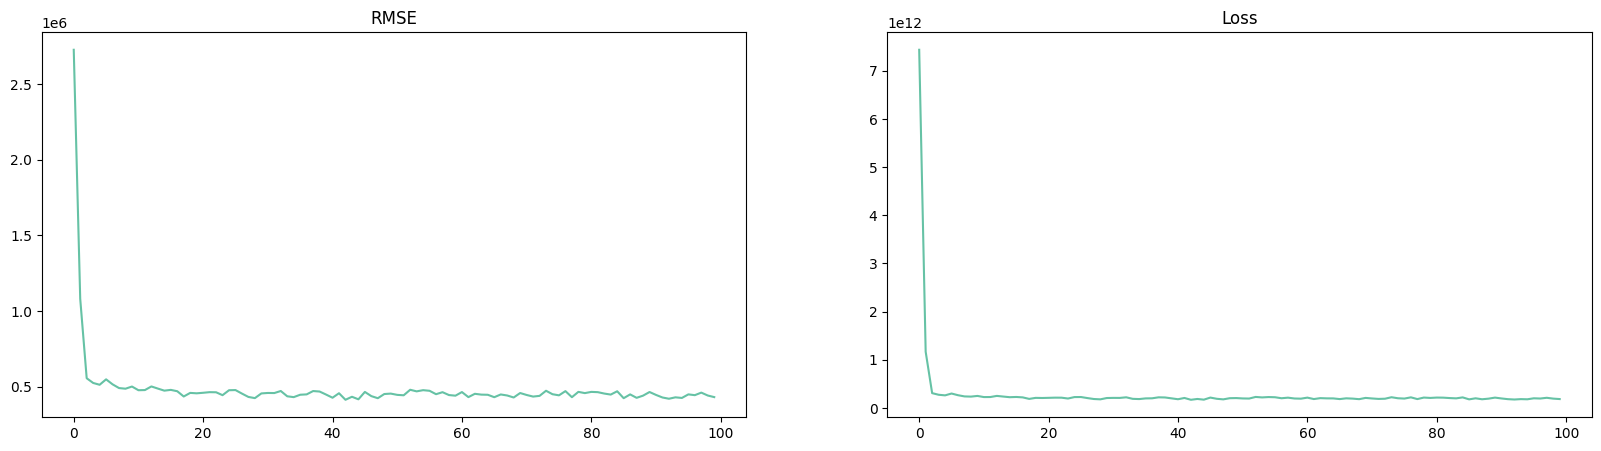

In [11]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [12]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 772234.4278026508
MAE: 511444.3558067376
MAPE: 0.5093616606479024


In [13]:
df_geral["standard scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

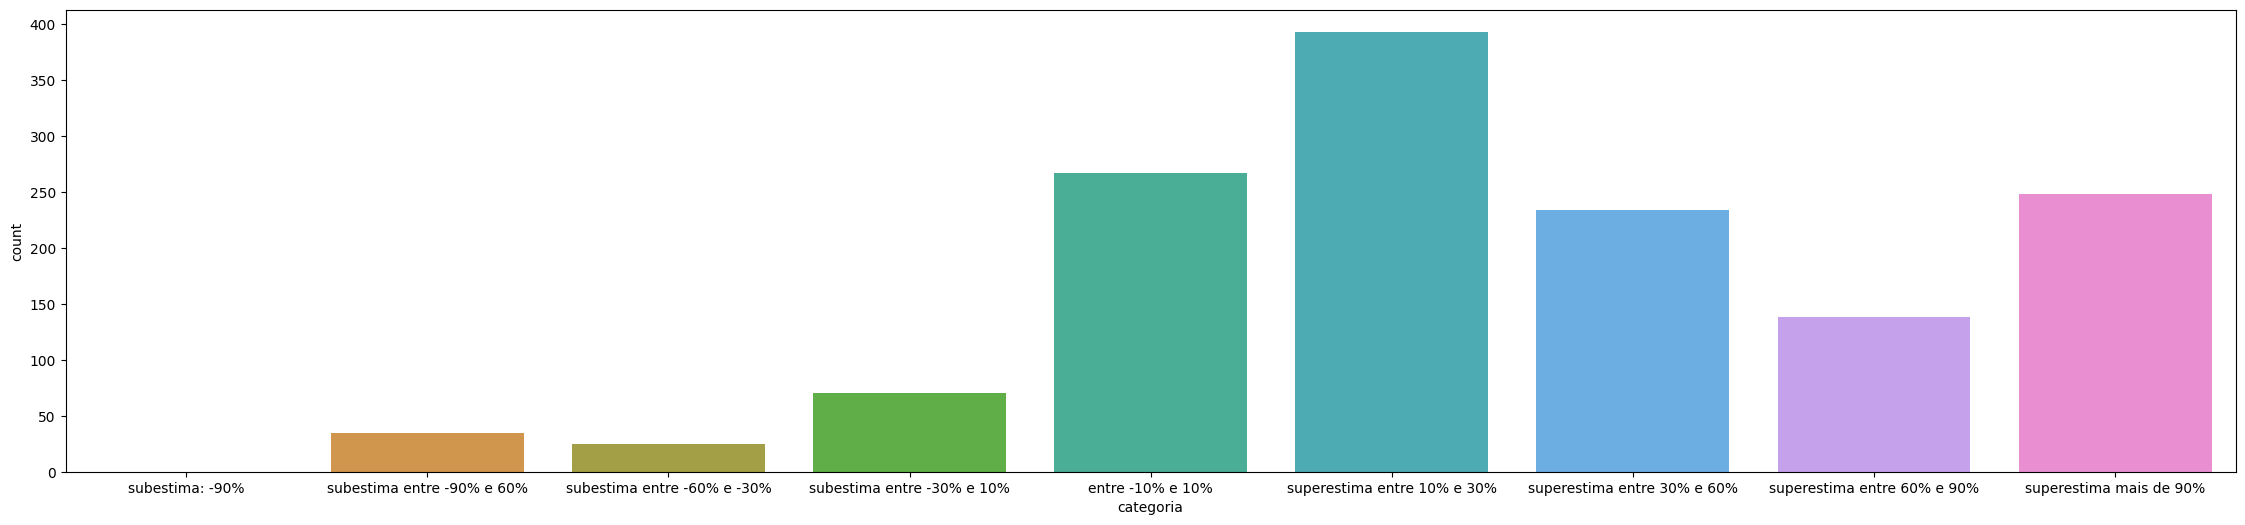

In [16]:
show_delta(np.array(y_test), y_pred.flatten())

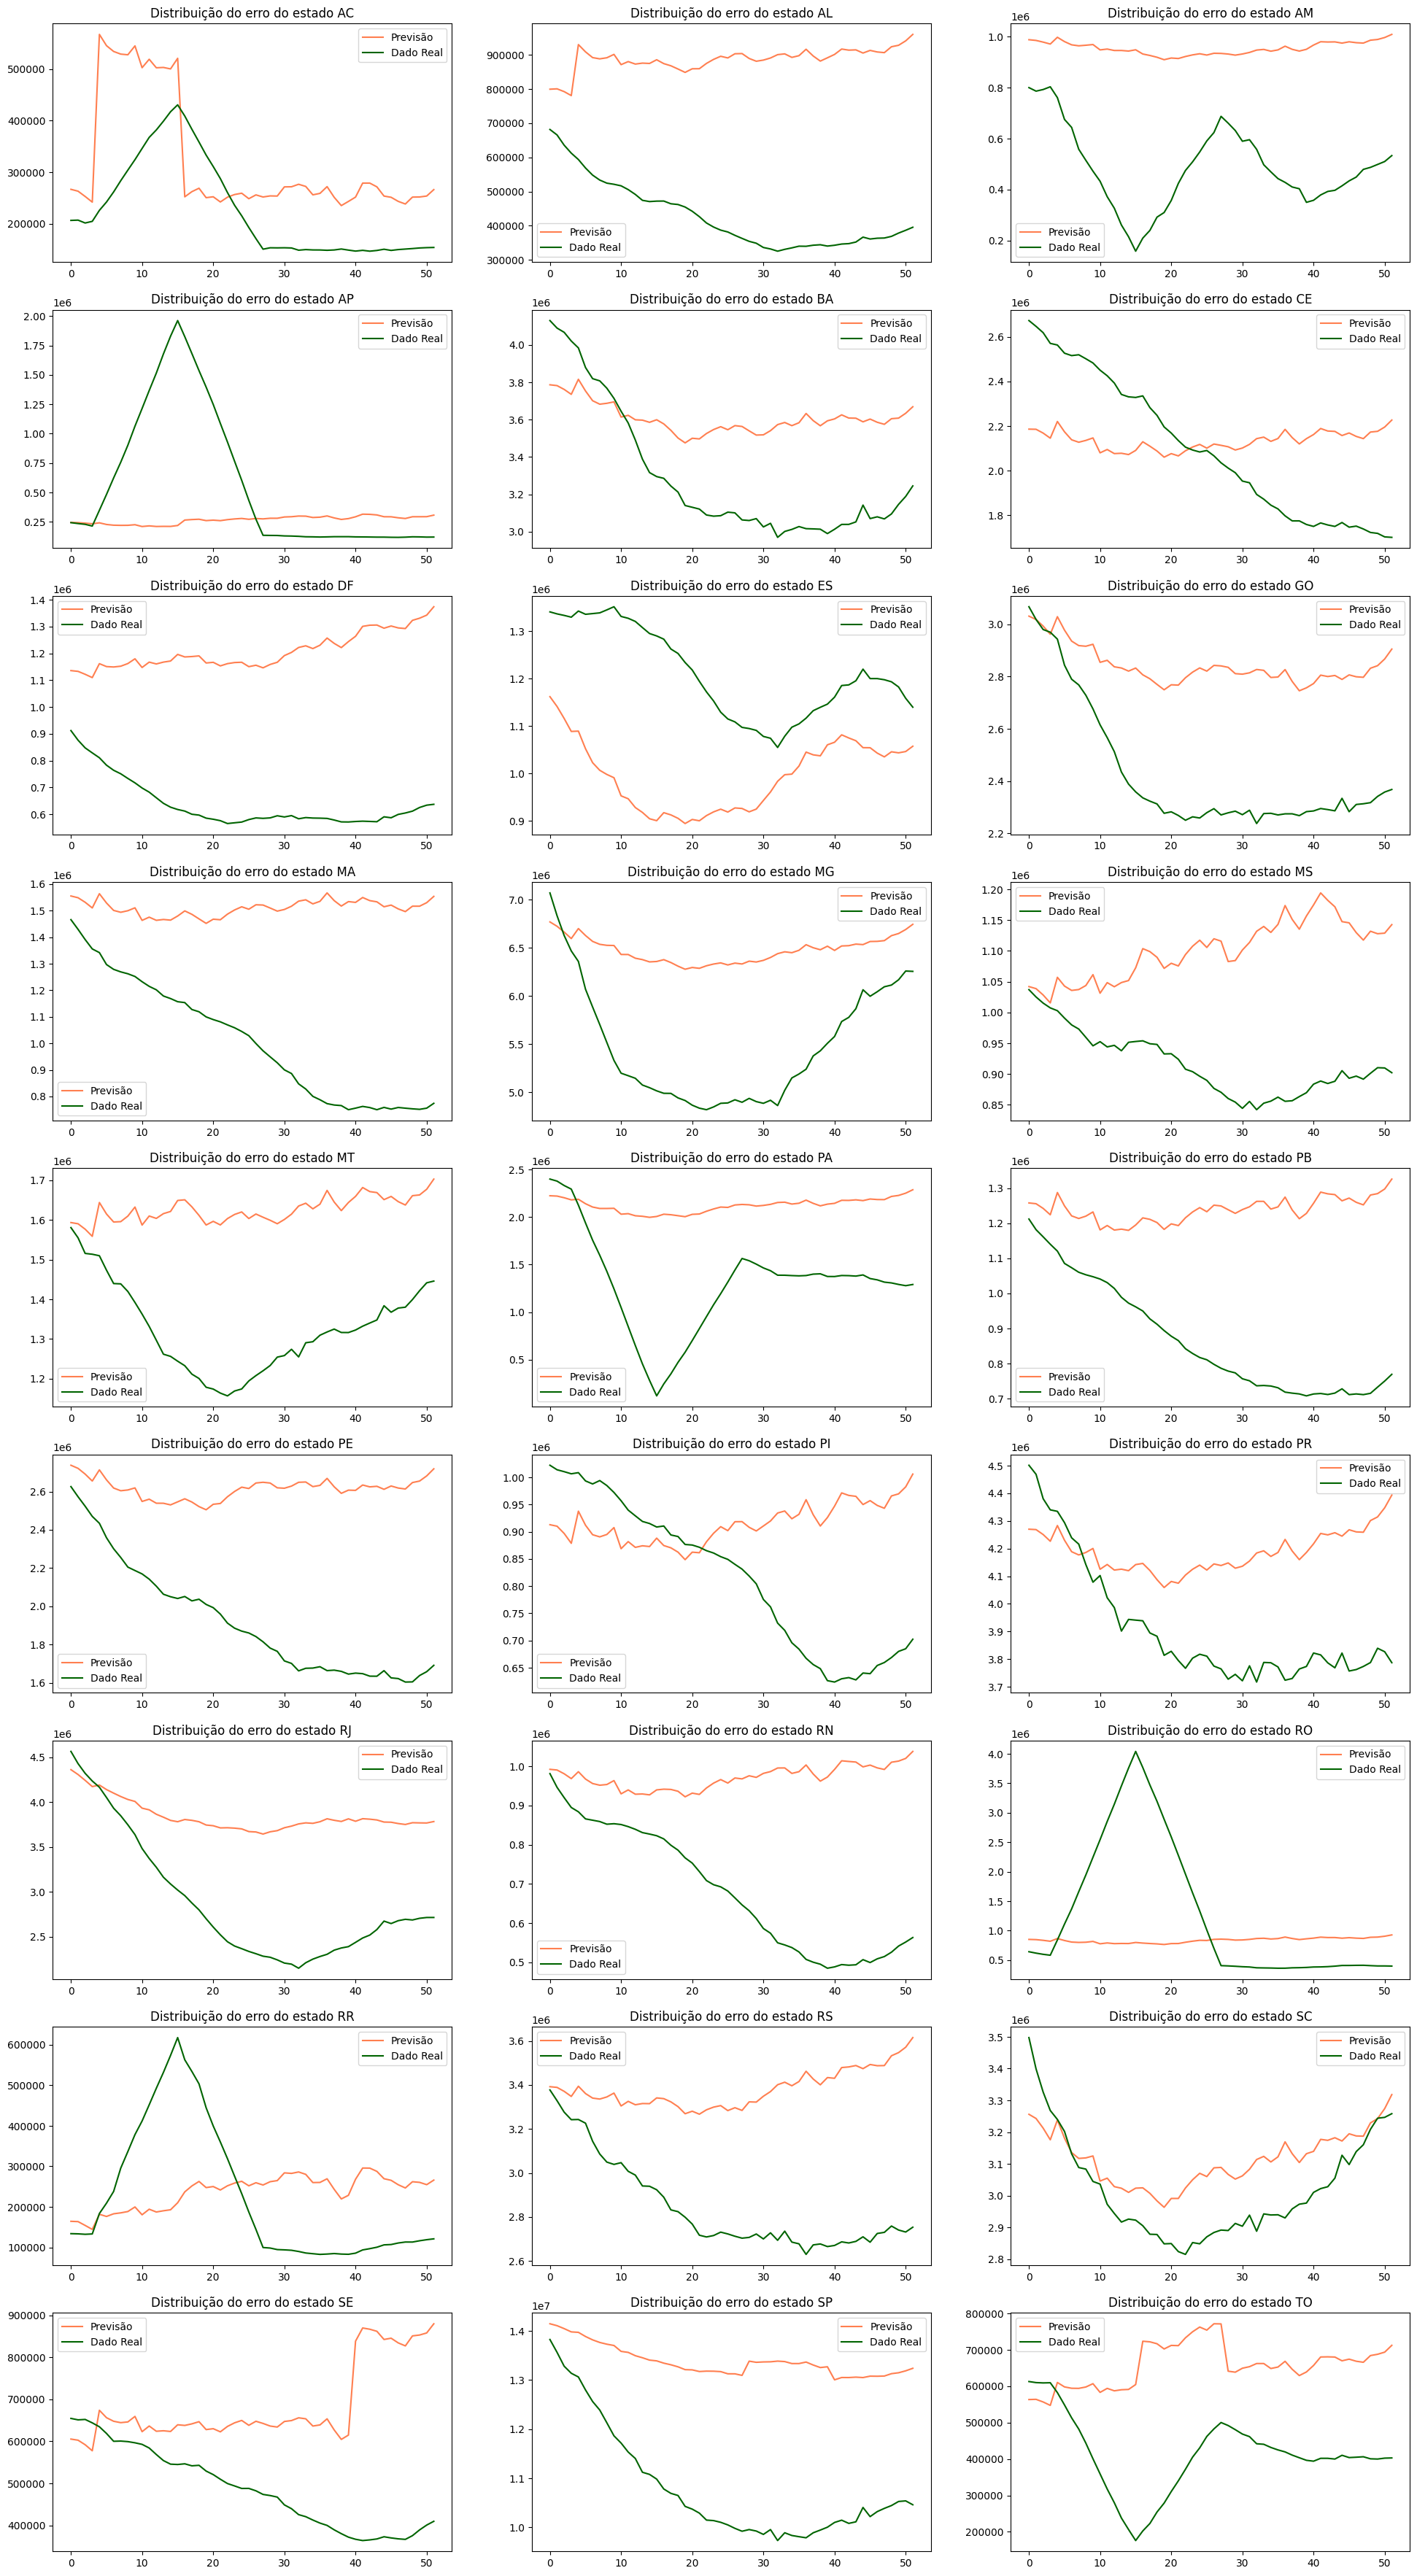

In [17]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## MinMax Scaler

In [18]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

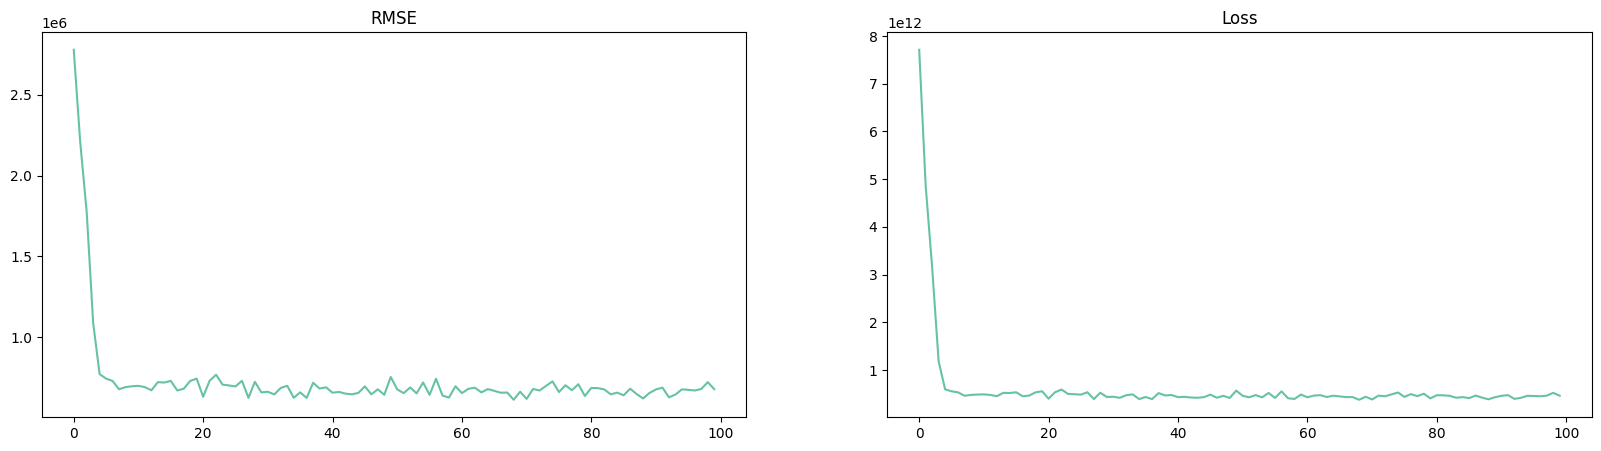

In [19]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [20]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 907531.3988588067
MAE: 532248.7526817375
MAPE: 0.4245710647295361


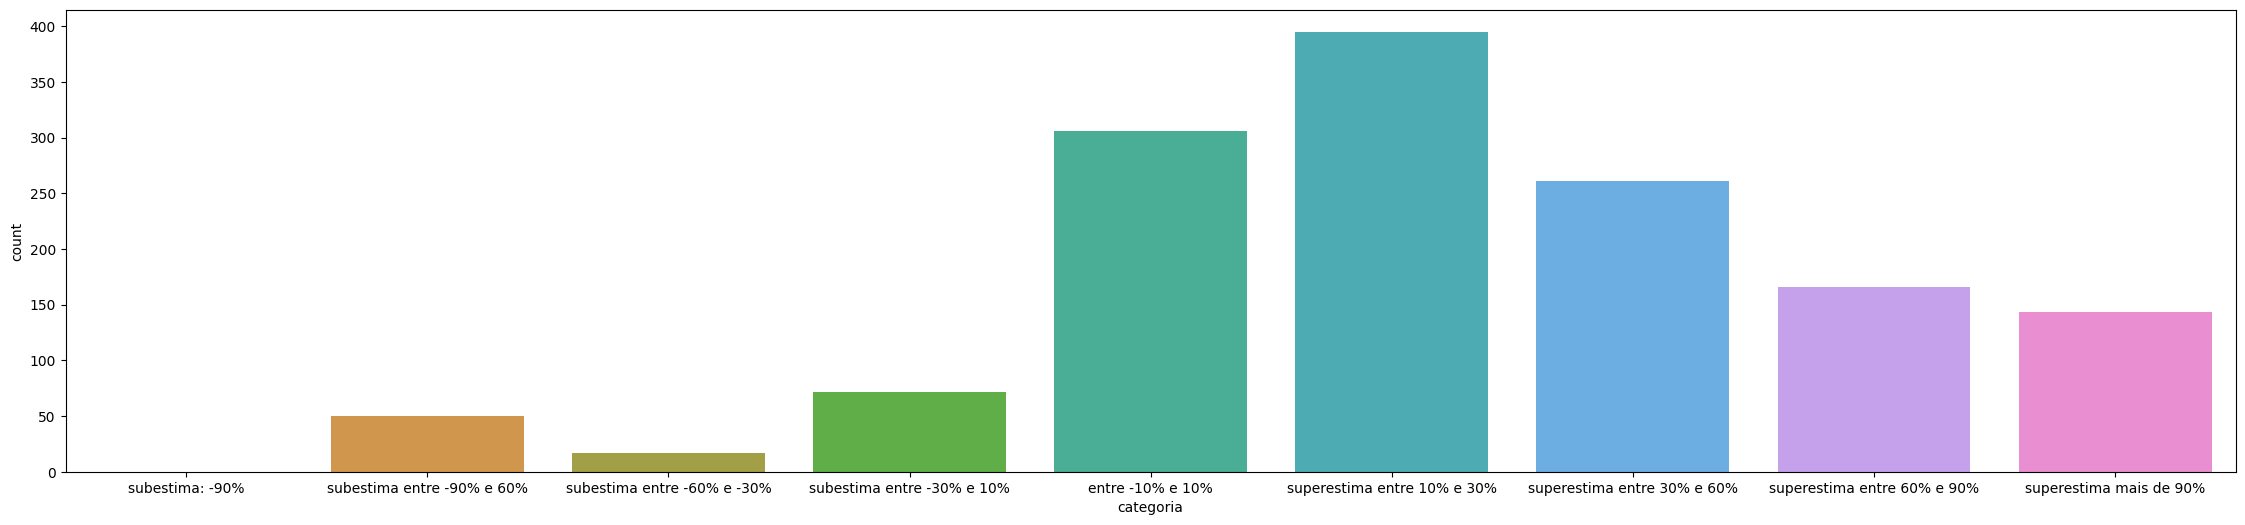

In [21]:
show_delta(np.array(y_test), y_pred.flatten())

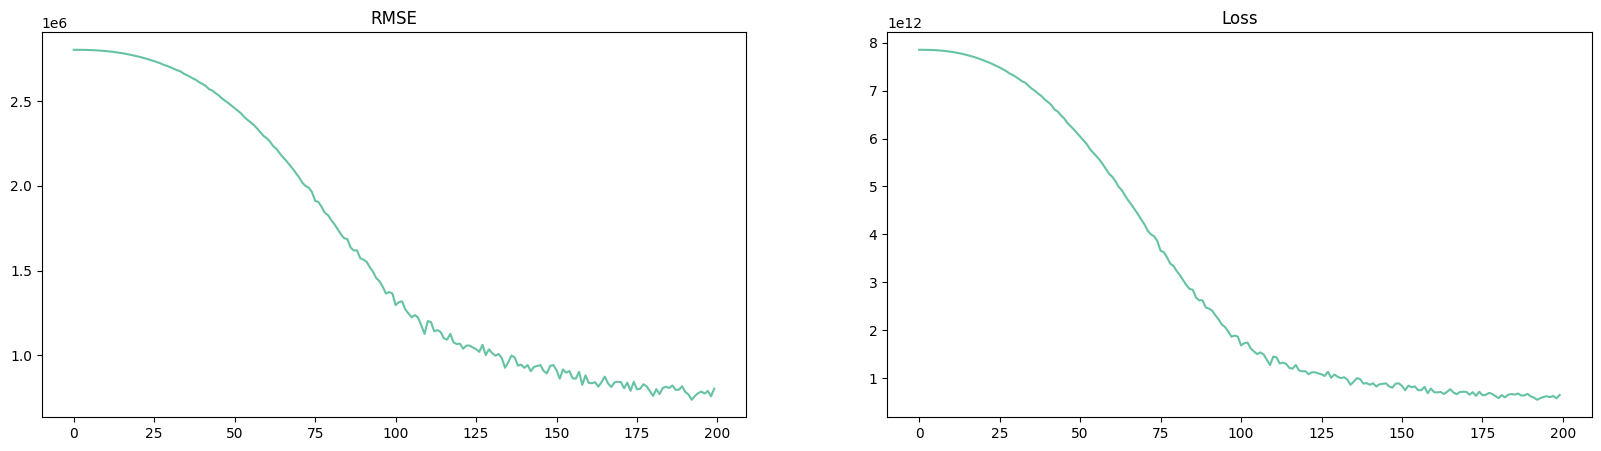

In [22]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

#model.add(BatchNormalization())
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(BatchNormalization())

model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [23]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 1135350.4073263495
MAE: 653928.9432624114
MAPE: 0.6325519949731189


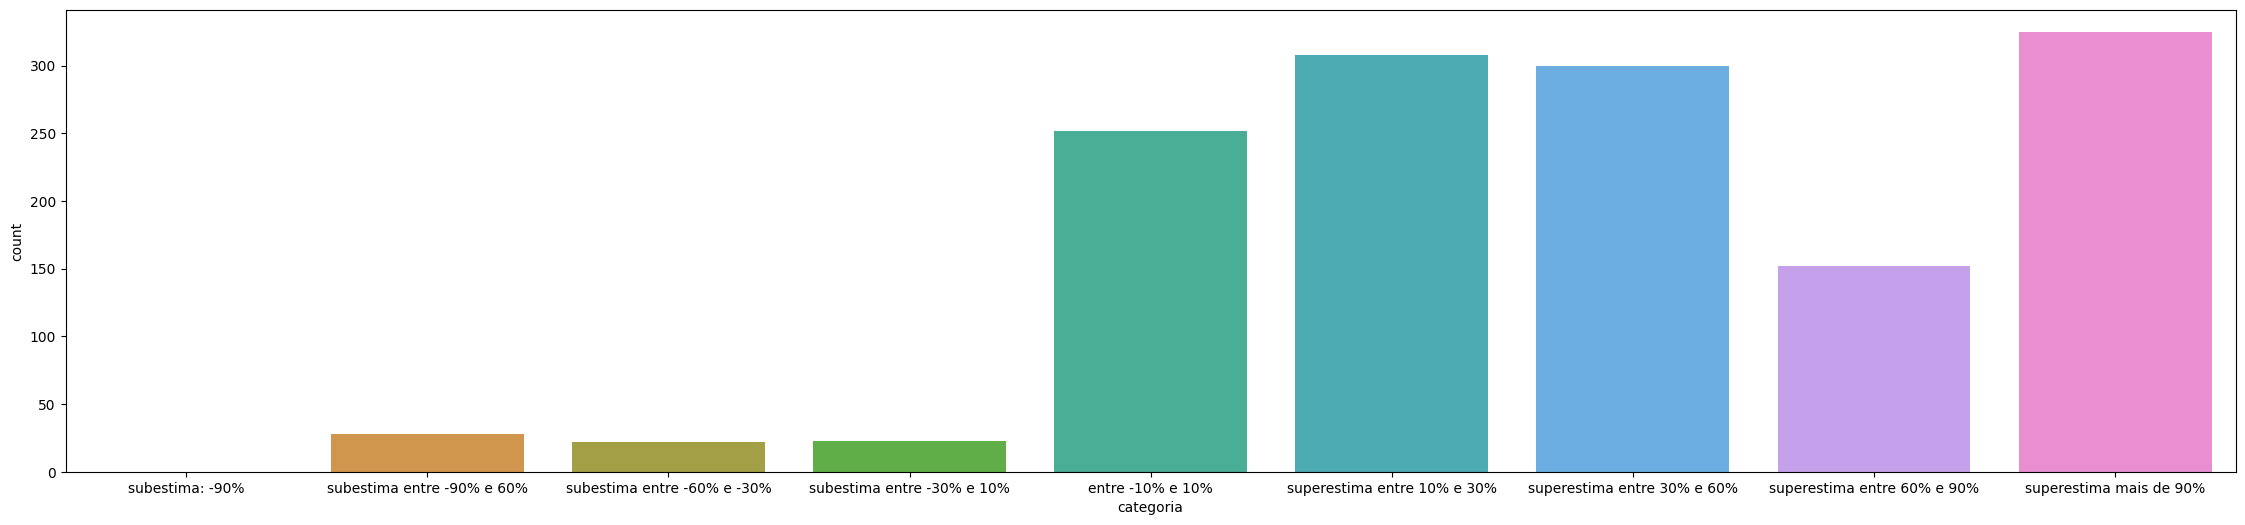

In [24]:
show_delta(np.array(y_test), y_pred.flatten())

In [25]:
df_geral["minmax scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

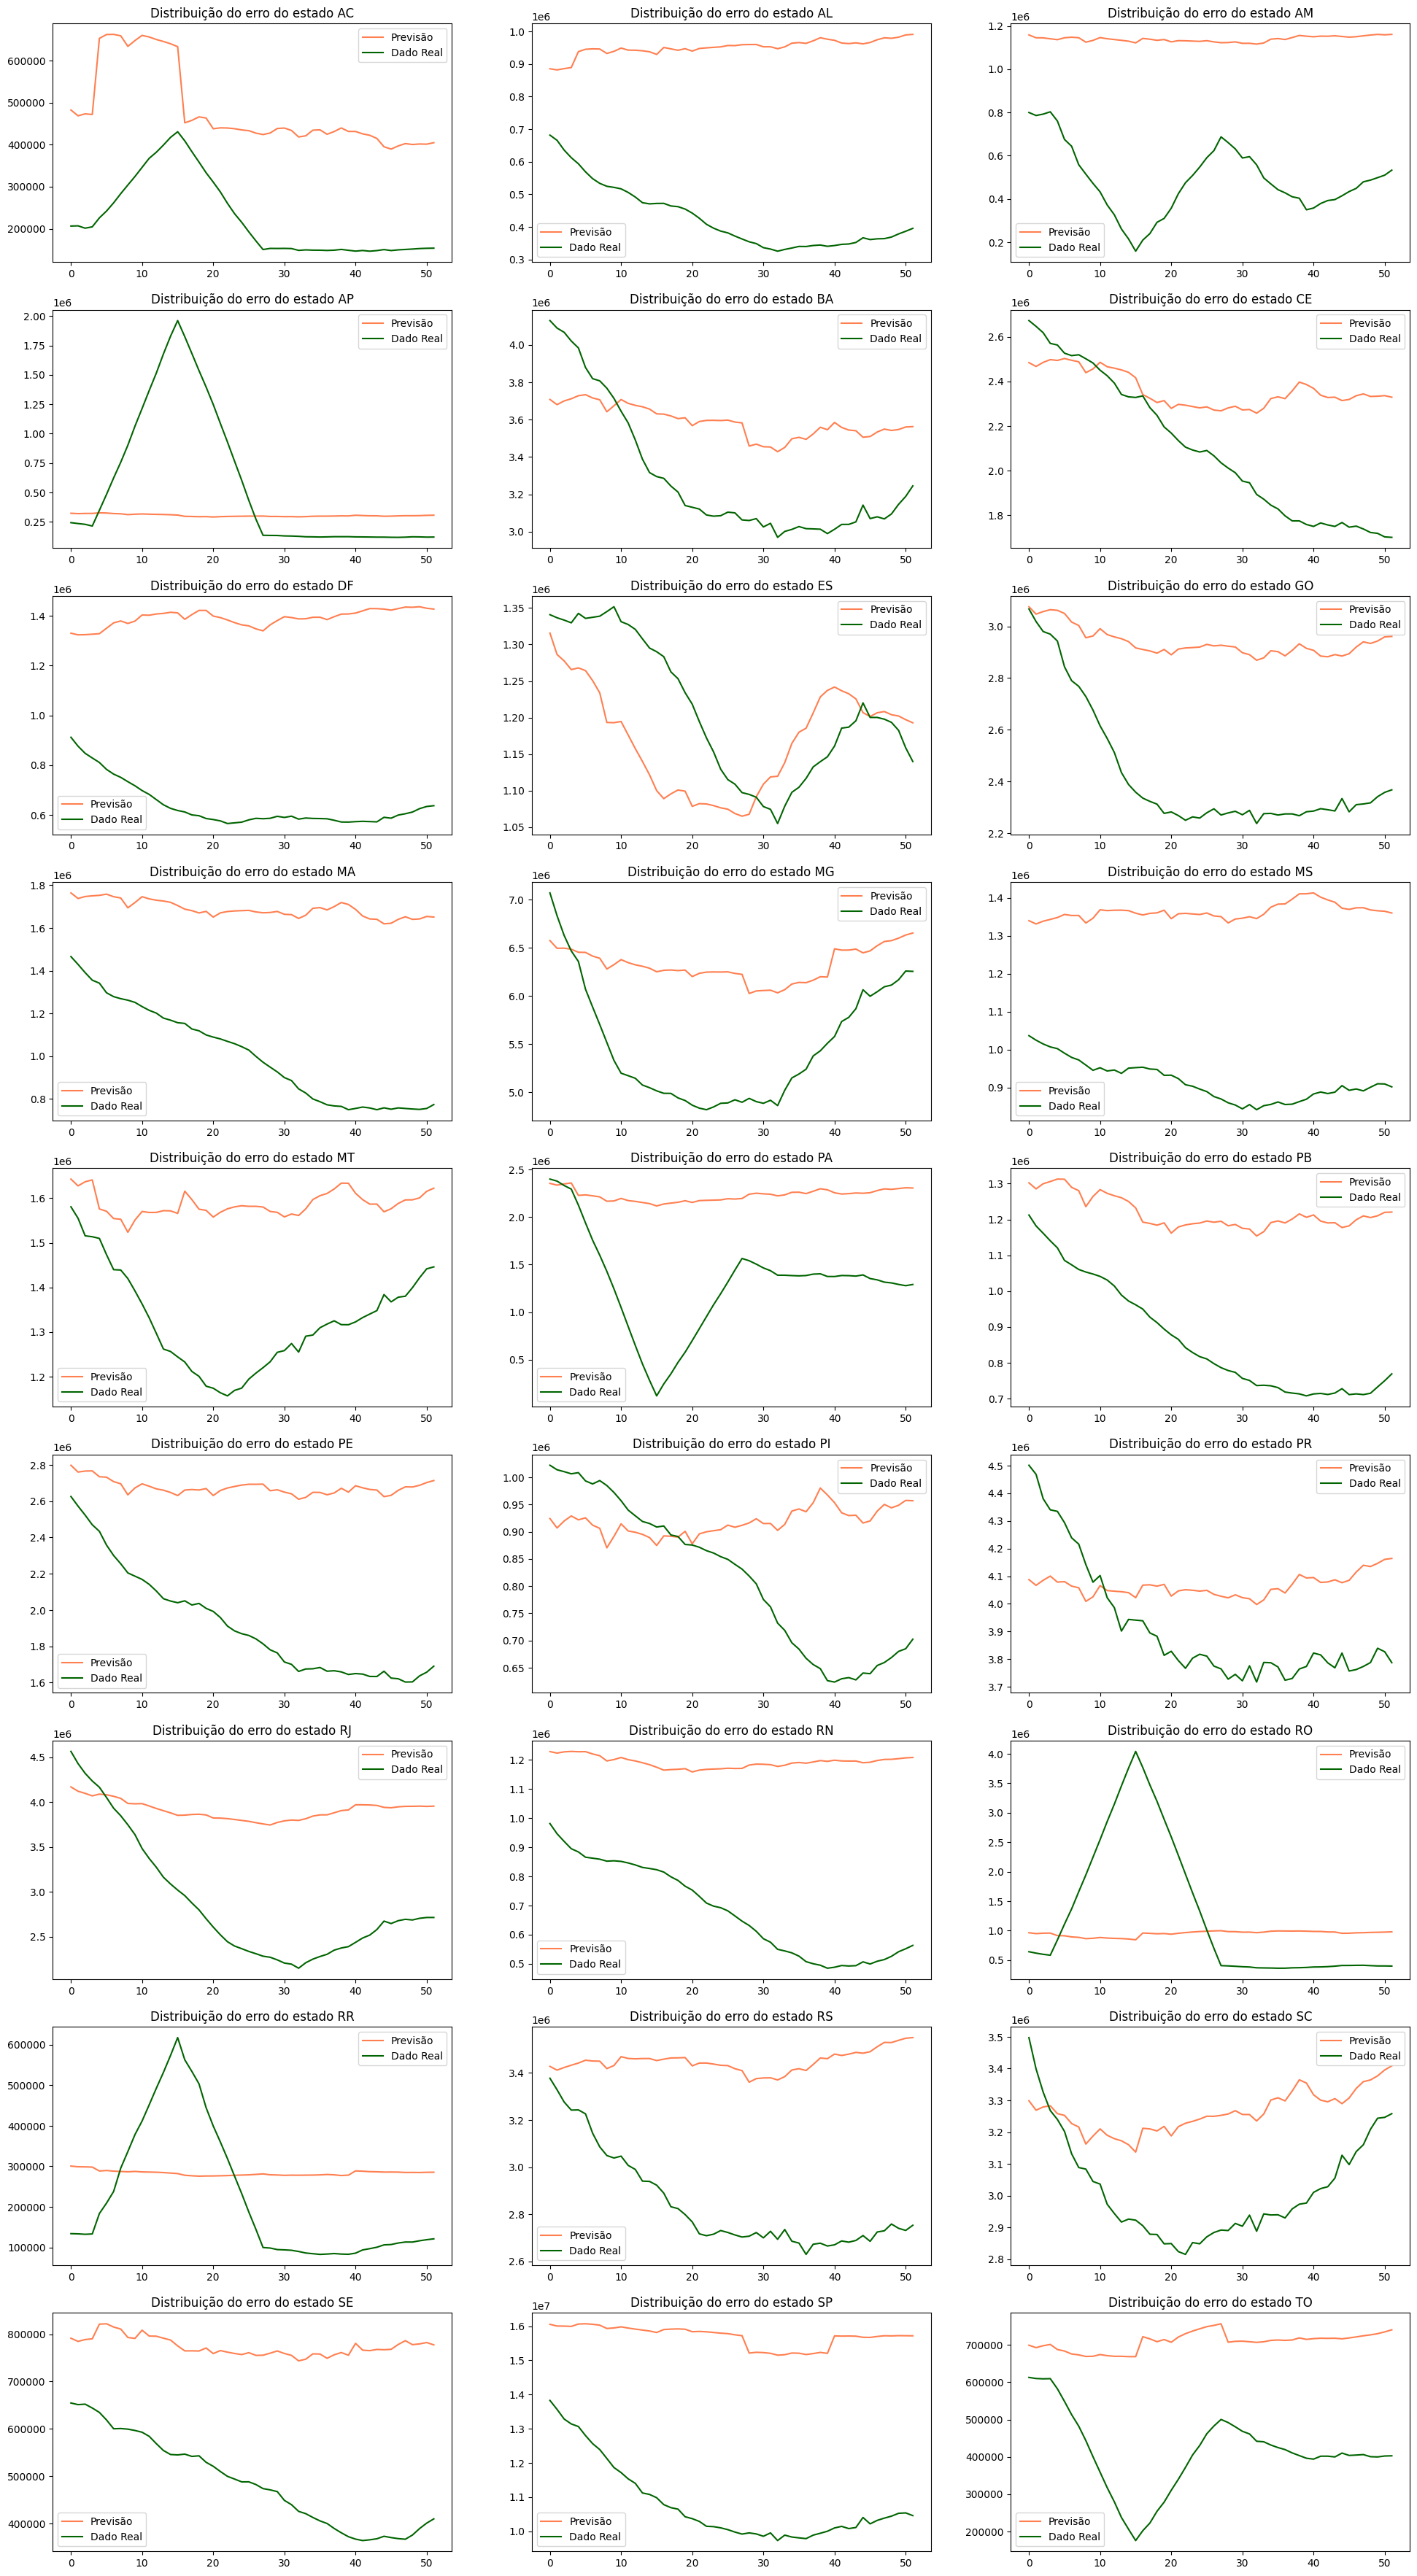

In [26]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## PowerTransform 

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),


model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

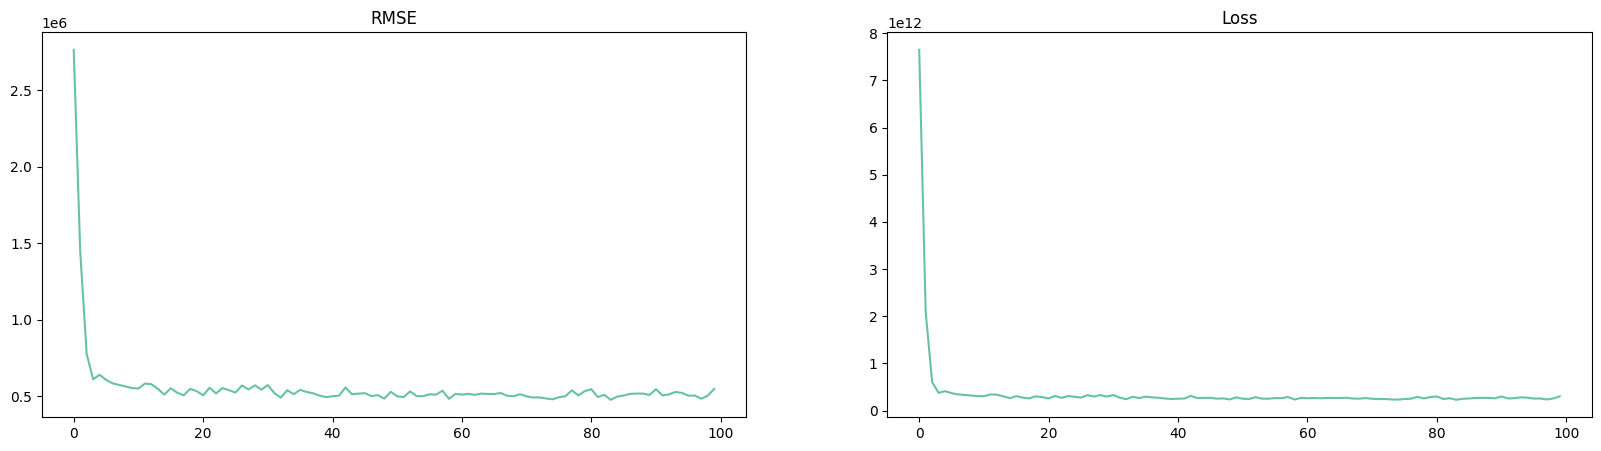

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [29]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 791401.1991095454
MAE: 469601.0142508865
MAPE: 0.42804254973595357


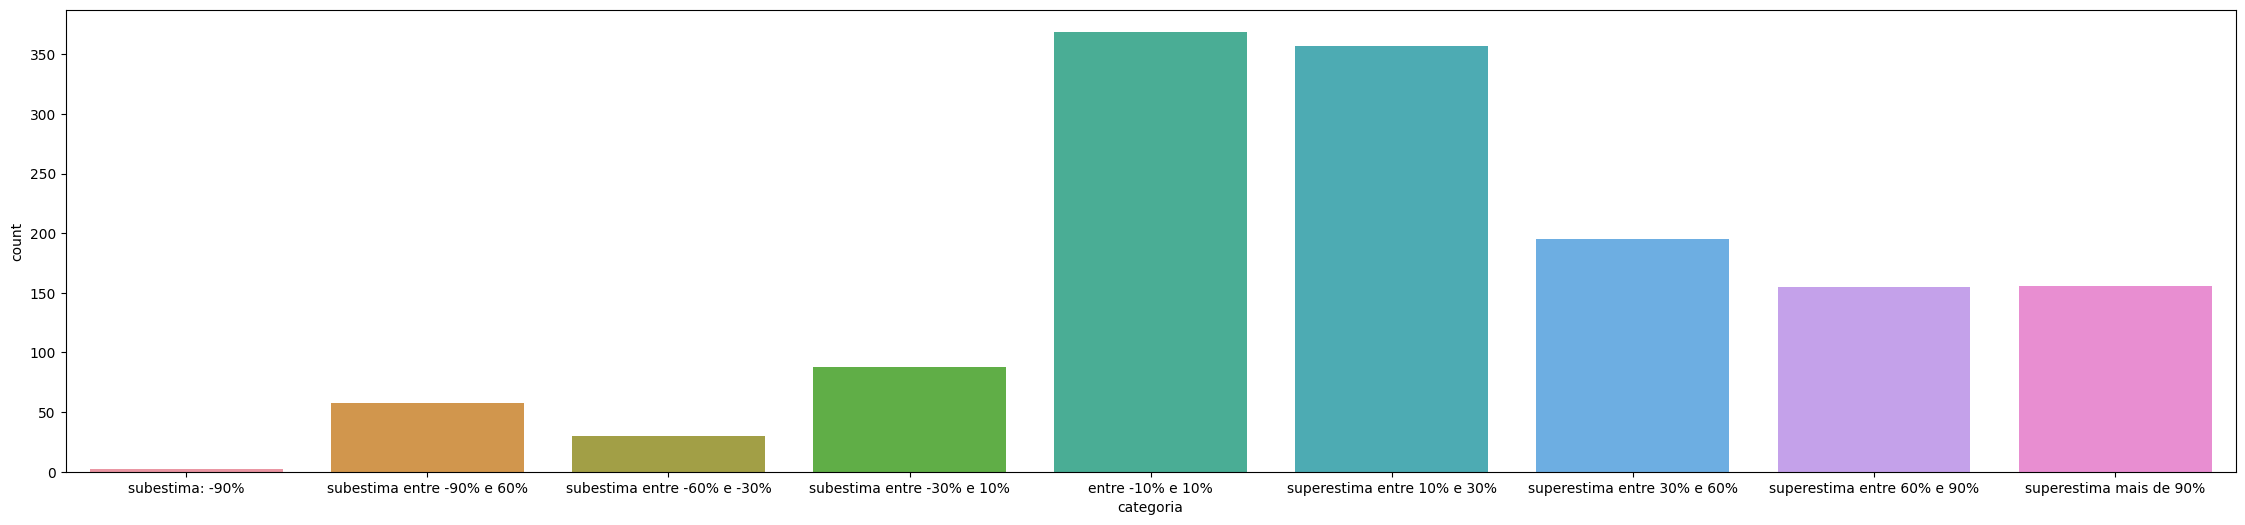

In [30]:
show_delta(np.array(y_test), y_pred.flatten())

In [31]:
df_geral["powertransform"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

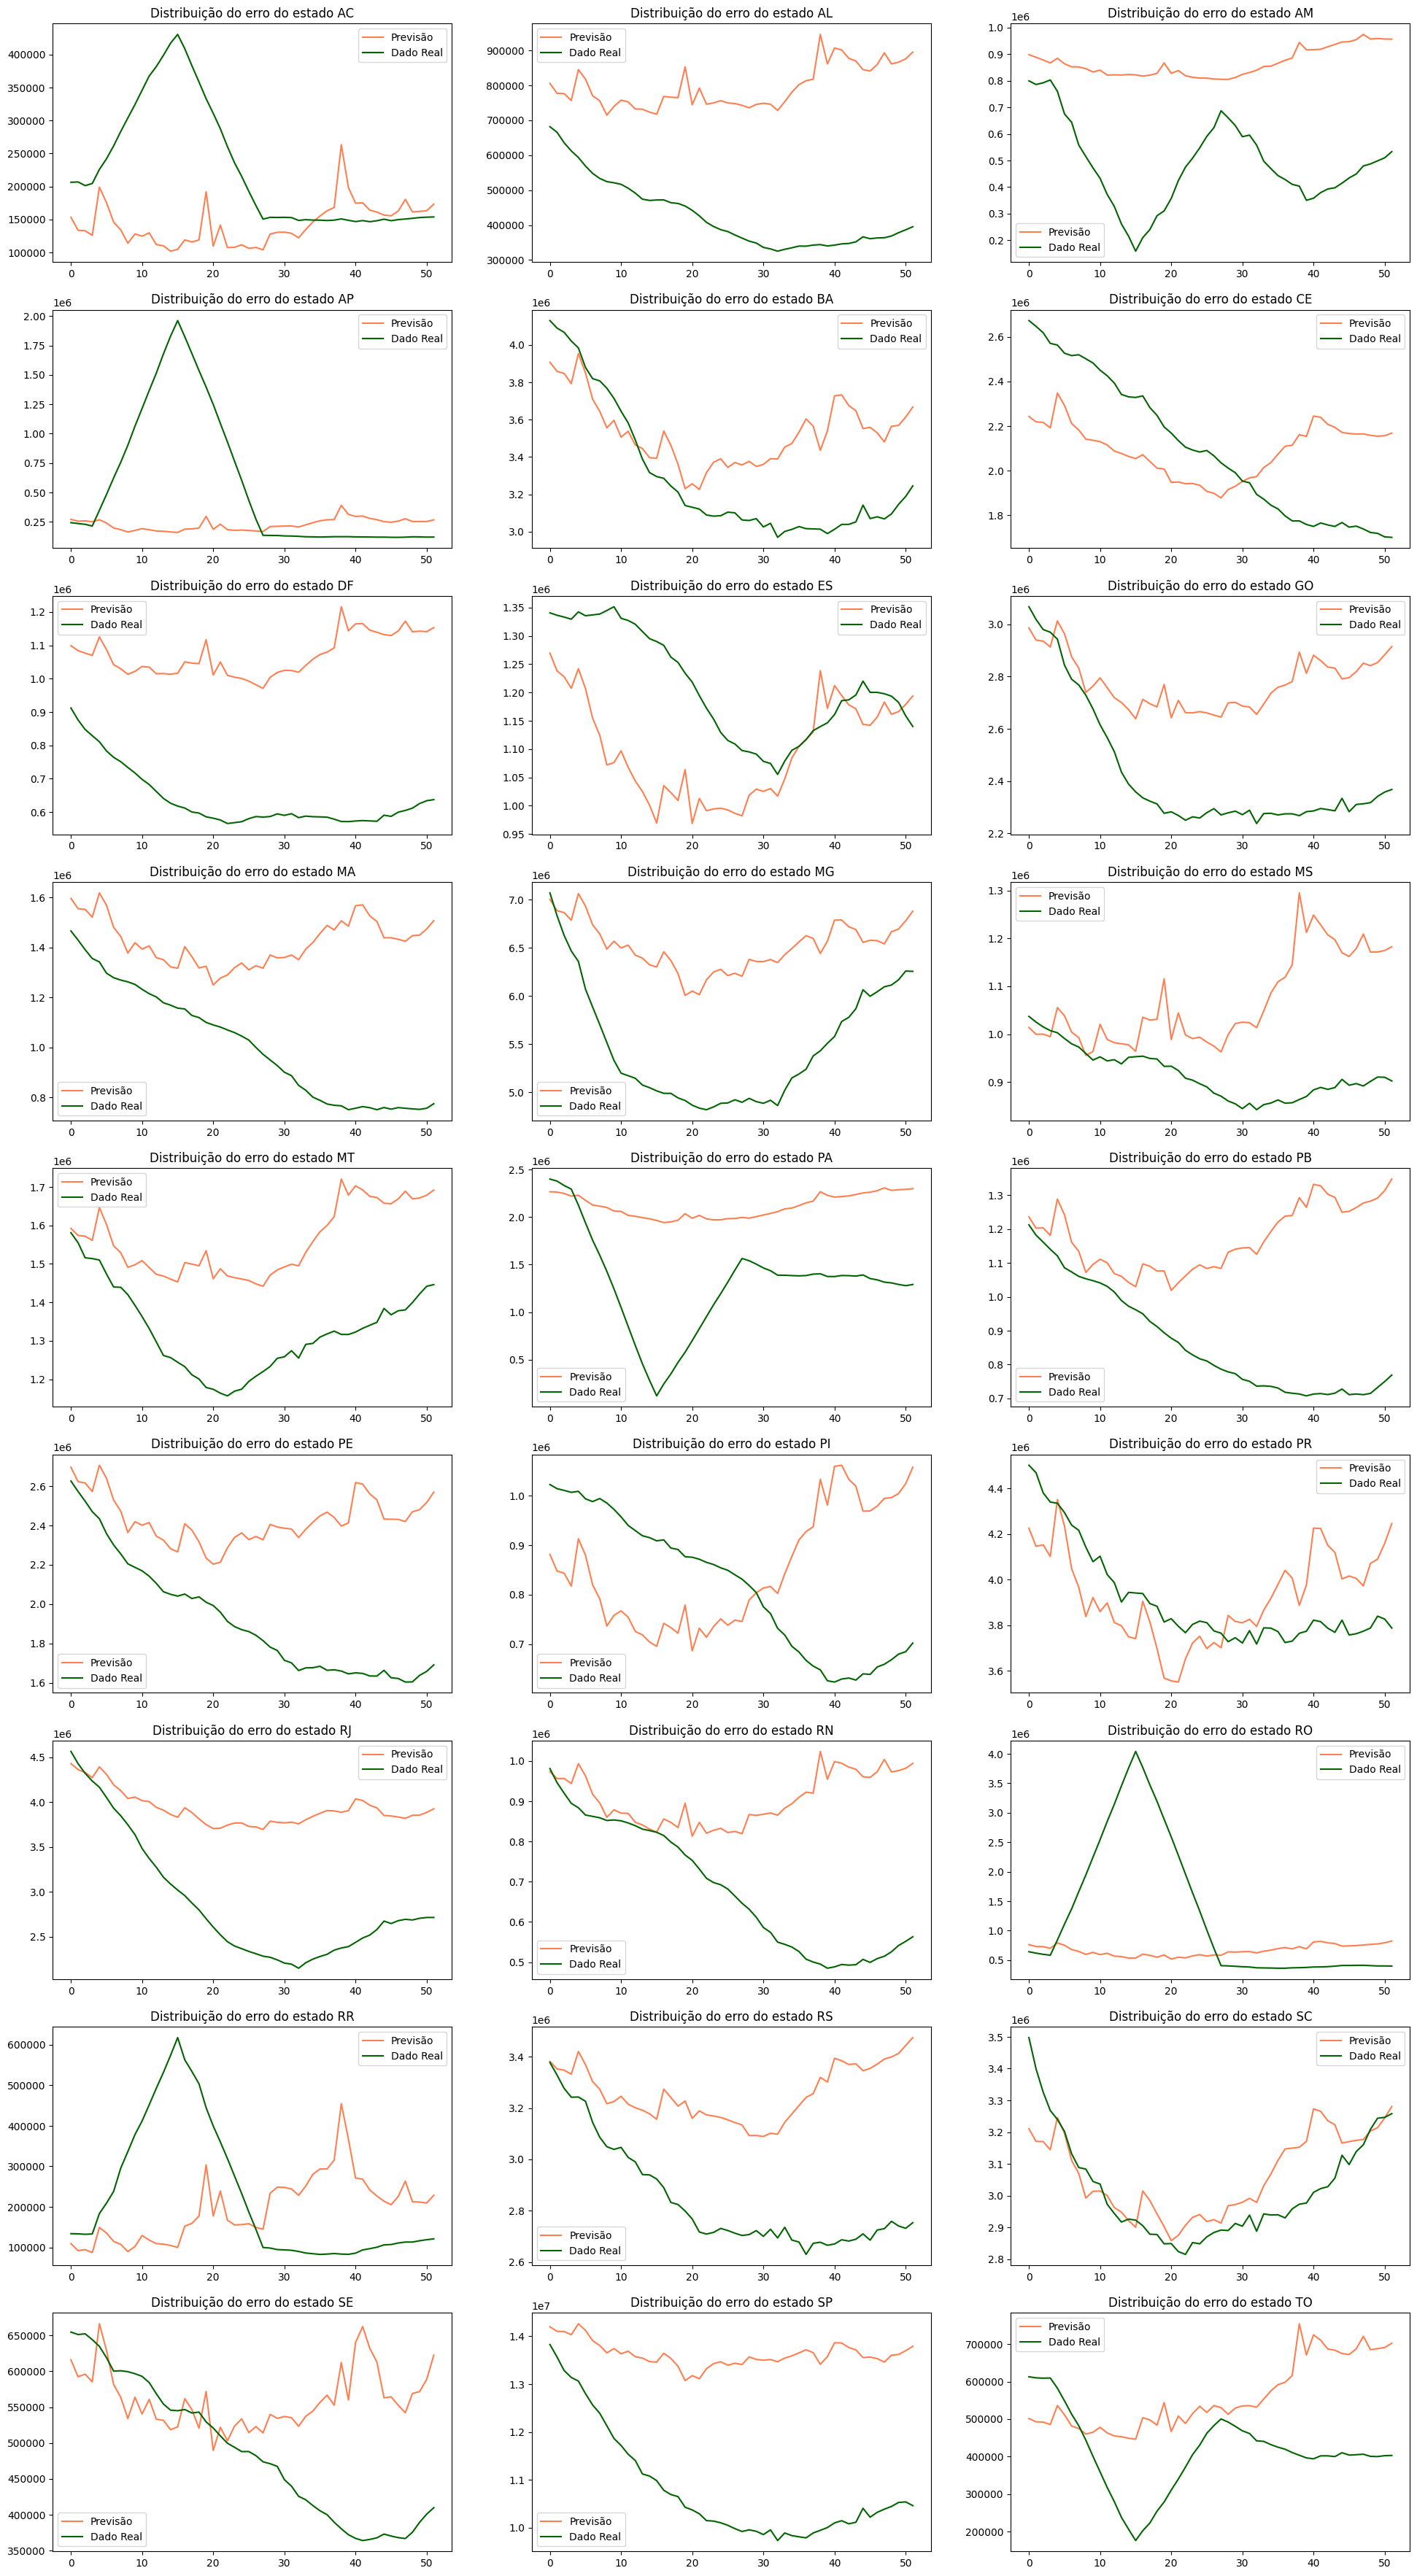

In [32]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)